## NFW Profile Model for Red LSBG Tangential Shear Measurements 

In this notebook, we walk through generating a model composed of two NFW profiles to represent the tangential shear measurements for the red sample of the low surface brightness galaxy catalog. We use two NFW profiles to indicate the subhalo term and the host halo term of the measurements.  We rely on [colossus](https://bdiemer.bitbucket.io/colossus/cosmology_cosmology.html) for our base cosmology and [profiley](https://github.com/cristobal-sifon/profiley) to implement the NFW profiles. 

In [1]:
#Loading packages
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import twopoint
from profiley.nfw import TNFW, NFW
import scipy.stats as stats
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15');
from astropy.cosmology import Planck15
from astropy import constants as const
import twopoint
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### Measurements

We load in the red LSBG measurements (calculated using [TreeCorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html)) found in the data file of this repository. Theta_red represents the angular scales of the measurements, xi_red indicates the shear signal, error_red stands for the shot noise, and err_jk_red represents the error derived from the jackknife covariance. We conduct all of our modeling using the red galaxy sample, as this sample produces the greatest shear signal. The blue and total galaxy samples can be found in the data file for additional testing. 

In [2]:
#Loading measurements
theta_red, xi_red, error_red, cross_term_red = np.loadtxt('../data/gt_LSBG_combined_sources_scales_3_red_ran', unpack=True)
theta_red, xi_red, err_jk_red, cross_term_red = np.loadtxt('../data/gt_LSBG_jackknife_combined_sources_scales_3_red_ran', unpack=True)
cov = np.loadtxt('../data/jkcov_gt_LSBG_combined_sources_scales_3_red_ran')


We define two functions to calculate the $\chi^2$ between the model and the tangential shear measurements and the $\Delta \chi^2$ between two models. 

In [3]:
#Chi2 function- quantitative difference between the model and the measurements
def chi2(cov, model, measurements):
    invcov = np.abs(np.linalg.inv(cov))
    chi2 = np.dot((measurements-model).T, np.dot(invcov, (measurements-model)))
    return chi2


In [8]:
#Deltachi2 function for calculating the difference between two models
def deltachi2(cov, model, measurements):
    invcov = np.abs(np.linalg.inv(cov))
    INVCOV = np.matrix(invcov)
    diff = np.matrix((model).T[0]-(measurements).T[0])
    deltachi2 = diff*INVCOV*diff.T
    return deltachi2

We construct a function to easily normalize distributions. 

In [13]:
#function arguments can be zl, for the normalization of the lens redshift distribution, offset, for the offset distribution, or zs, for the source redshift distribution
def normalization(mean=None, sigma=None, size=None, func=None, ranged=None, bins_weighted=None):
    if (func=='zl'): #Normalization for lens redshift distribution 
        func_range = np.linspace(mean - 2*sigma, mean + 2*sigma, size) #Range of lens redshift
        dist = stats.norm.pdf(func_range, mean, sigma) #Lens redshift distribution
        A_norm = np.trapz(dist) #Normalizing factor
        dist_norm = dist/A_norm
    if (func=='off'): #Normalization for offset distribution
        func_range = np.linspace(0, mean + 2*sigma, size) #Range of lens redshift
        dist = stats.norm.pdf(func_range, mean, sigma) #Lens redshift distribution
        A_norm = np.trapz(dist) #Normalizing factor
        dist_norm = dist/A_norm
    if (func=='zs'): #Normalization for source redshift distribution
        func_range = ranged #Predefined range- in this case zsbin
        dist = np.sum(bins_weighted, axis=0) #Distribution based on summed, weighted redshift bins
        A_norm = np.trapz(dist)
        dist_norm = dist/A_norm
    return func_range, dist, A_norm, dist_norm

We construct a function to generate a simple NFW profile, along with the $\Sigma_\mathrm{crit}$ factor

In [14]:
def nfw_generation(mass=None, concentration=None, zl=None, zs=None, scales=None):
    da = Planck15.angular_diameter_distance(zl) 
    r_mpc = da*scales #Conversion to physical scales based on redshift
    nfw = NFW(mass, concentration, zl) #NFW profile construction 
    sigma_crit = nfw.sigma_crit([zs]) #Sigma_crit construction
    return da, r_mpc, nfw, sigma_crit

We construct a function to generate the offset distribution. 

In [15]:
def offset_generation(offset=None, zl=None, size=None):
    da_roff = Planck15.angular_diameter_distance(zl) #Angular diameter distance at this particular redshift
    marker_roff = np.array(offset*da_roff) #Determining offset for this particular redshift (marker offset)
    sigma_roff = np.sqrt(marker_roff) #Defined sigma value for offset distribution
    r_off_range, r_off_dist, A_off, r_off_norm = normalization(marker_roff, sigma_roff, size, 'off') #Each redshift corresponds to a different range of roffs and a different distribution based around the offset
    return r_off_dist, r_off_norm

### Source Redshift Distribution

We load in the source redshift catalog. The catalog presents the source redshifts divided into four tomographic bins, which we weight by galaxy count, sum, and normalize to produce our source redshift distribution. We plot each of the weighted redshift bins and compare to the total distribution. 

In [16]:
#Finding mean source redshift 
T = twopoint.TwoPointFile.from_fits('../data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits') #Loading files
T.kernels[0].name
nzs = (T.kernels[0].nzs) #Galaxy counts
zsbin = (T.kernels[0].z) #Redshift spread

#Weighting the source redshift bins by galaxy count
nzs_count = np.array([24940465,25280405,24891859,25091297])
nzs_total = np.sum(nzs_count)
bins_weighted = []
for i in range(4): #Weighting bins
    bin_weighted = (nzs[i]*nzs_count[i]/nzs_total)
    bins_weighted.append(bin_weighted)

#Normalizing distribution
zsbin, zsdist, A_zs, zsdist_norm = normalization(func='zs', ranged=zsbin, bins_weighted=bins_weighted)


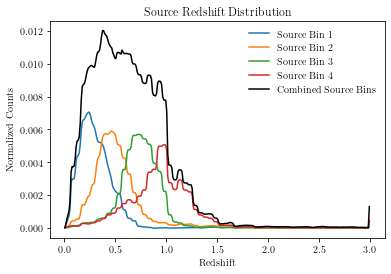

0.6312412596033679


In [44]:
#Plotting the weighted source redshift bins
for i in range(4):
    plt.plot(zsbin, bins_weighted[i], label='Source Bin '+str(i+1))
plt.plot(zsbin, zsdist_norm, color='black', label='Combined Source Bins') #Plotting normalized source redshift distribution

plt.legend(frameon=False)
plt.xlabel('Redshift')
plt.ylabel('Normalized Counts')
plt.title('Source Redshift Distribution')
plt.show()

#Printing out mean redshift
z_mean_s = np.average(zsbin, weights=zsdist_norm)
print(z_mean_s)

### Defining Parameters

We define the parameters for the model. The NFW profile parameters include the lens redshift, the concentration (fixed at 2.0), and the mass. We require the source redshift to produce the $\Sigma_{\mathrm{crit}}$, a geometrical lensing factor that varies with the characteristics of the lensing system. Our mass terms and our mean lens redshift come from posteriors obtained with an MCMC. We build a gaussian around this mean lens redshift to construct our distribution. Our scales and our offset term (used to define the offset of the host halo profile) come from our measurements. We build a distribution of offsets based around the offset term.   

In [18]:
#Model Parameters
#These parameters have been altered by playing with the chi^2 by hand
zl = 0.011 #Old model lens redshift: 13.2e-3 (from MCMC posterior)
zl_sigma = 0.005 #Spread of lens redshift distribution- made smaller to avoid negative redshifts
concentration = 2. #Concentration (taken from Sifon et al 2018)
zs = z_mean_s
theta_arcmin = np.geomspace(0.25, 1000, 25) #Scales of model
theta_rad = theta_arcmin/60*np.pi/180 
mass_term1 = 1e9 #Old model subhalo mass: 9.9e10 
mass_term2 = 5e10 #Old model host halo mass12.2e14 
offset_rad = 14/60*np.pi/180 #Scales of offset 

### Model

We build our total model from two NFW profiles to represent the subhalo and host halo term of the shear measurements. We convert our angular scales to physical scales using the selected lens redshift and construct a normalized Gaussian distribution around this redshift. We then build the subhalo NFW term using the first mass term, the concentration, and the selected lens redshift. We use the mean source redshift to create the $\Sigma_\mathrm{crit}$ term. We calculate the excess surface density and the tangential shear for each of the 25 NFW profiles and integrate all of these terms over the normalized lens redshift distribution. We repeat this process for the host halo term, but we alter the scales by a normalized offset distribution and integrate over this distribution. We sum these two integrated profiles to find our total model.

In [23]:
#Shear model
def total_model(mass_term1=None, mass_term2=None, concentration=None, zs=None, zl_mean=None, zl_sigma=None, offset=None, scales=None):
    #Lens redshift distribution
    zlrange, zldist, A_zl, zldist_norm = normalization(mean=zl_mean, sigma=zl_sigma, size=30, func='zl') 
    
    #Subhalo NFW
    gt_term1_list = []
    for i, xi in enumerate(zlrange):
        #Calculate the angular diameter distance for a single redshift
        da_term1, r_mpc_term1, nfw_term1, sigma_crit_term1 = nfw_generation(mass=mass_term1, concentration=concentration, zl=xi, zs=zs, scales=scales)
        esd_term1 = nfw_term1.projected_excess(r_mpc_term1)
        gt_term1 = esd_term1/sigma_crit_term1
        gt_term1_norm = gt_term1*zldist_norm[i] #We multiply by the normalized lens redshift value at the index of the current redshift
        gt_term1_list.append(gt_term1_norm) 
    gt_term1_list = np.array(gt_term1_list)
    I_calc_term1 = np.trapz(gt_term1_list, axis=0) #Integrate over all of the lens redshifts
    
    #Offset
    r_off_dist_list = []
    r_off_norm_list = []
    
    for i, xi in enumerate(zlrange):
        r_off_dist, r_off_norm = offset_generation(offset=offset_rad, zl=xi, size=40)
        r_off_dist_list.append(r_off_dist) #List of regular r_off_dist 
        r_off_norm_list.append(r_off_norm) #List of normalized r_off_dist for different redshifts- each of the 30 redshifts has a 40 point distribution
    #We integrate over the 40 points to have a single normalized offset value corresponding to each redshift
    r_off_norm_int = np.trapz(r_off_norm_list, axis=1)
    
    #Host halo NFW
    gt_term2_list = []
    for i, xi in enumerate(zlrange):
        #Calculate the angular diameter distance, physical distance, nfw profile, and sigma_crit for a single redshift
        da_term2, r_mpc_term2, nfw_term2, sigma_crit_term2 = nfw_generation(mass=mass_term2, concentration=concentration, zl=xi, zs=zs, scales=theta_rad)
        esd_term2 = nfw_term2.offset_projected_excess(np.array(r_mpc_term2), np.array(r_off_dist_list[i])) #We use the offset distribution value corresponding to this redshift
        gt_term2 = (esd_term2/sigma_crit_term2)*zldist_norm[i]*r_off_norm_int[i] #We multiply by both the normalized lens redshift distribution and normalized offset distribution
        gt_term2_list.append(gt_term2)
    gt_term2_list = np.array(gt_term2_list) 
    I_calc_term2_int = np.trapz(gt_term2_list, axis=1) #We integrate over the offset distribution
    I_calc_term2 = np.trapz(I_calc_term2_int, axis=0) #We integrate over the lens redshift
    total_model = I_calc_term1 + I_calc_term2 #Total model calculation
    
    return total_model, I_calc_term1, I_calc_term2 

In [24]:
#Call for model
total_model = total_model(mass_term1=mass_term1, mass_term2=mass_term2, concentration=concentration, zs=zs, zl_mean=zl, zl_sigma=zl_sigma, offset=offset_rad, scales=theta_rad)



### Comparison Between Model and Shear Measurements

We compare our models to our red LSBG shear measurements. Note that the model is a function of physical scales (R), while the measurements are functions of angular scales ($\theta$). The errorbars on the measurements come from the jackknife covariance. 

In [25]:
#Transfer from angular scales to physical scales based on redshift
zlrange = normalization(mean=zl, sigma=zl_sigma, size=30, func='zl')[0] #We pull out the lens redshift range
r_mpc_spread = []
for i, xi in enumerate(zlrange): #We loop through the lens redshifts and calculate the physical distance at each redshift
    da = Planck15.angular_diameter_distance(xi)
    r_mpc = da*theta_rad
    r_mpc_spread.append(r_mpc)
r_mpc_spread = np.array(r_mpc_spread) 
r_mpc_scales = np.trapz(r_mpc_spread, axis=0) #We integrate over the lens redshift distribution

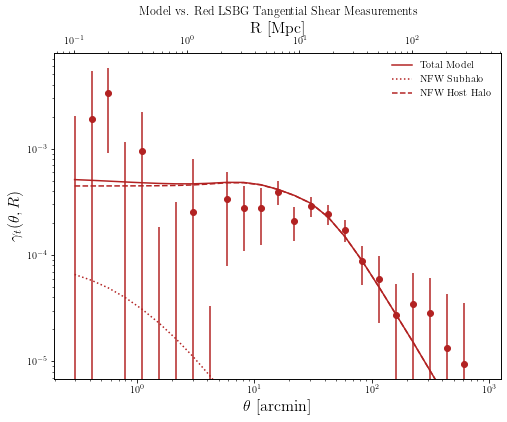

In [42]:
#Plot for measurements compared to model
fig, ax1 = plt.subplots(figsize=(8,6), ncols=1)
ax1.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color="firebrick", label="Red Galaxies") #Measurements over angular scales 
ax2 = ax1.twiny()
ax2.plot(r_mpc_scales, total_model[0], color='firebrick', label = 'Total Model') #Secondary axis- model over physical scales
ax2.plot(r_mpc_scales, total_model[1], ls=':', color='firebrick', label='NFW Subhalo')
ax2.plot(r_mpc_scales, total_model[2],ls='--', color='firebrick',label='NFW Host Halo')

ax1.set_ylabel(r'$\gamma_t(\theta, R)$', fontsize=16)
ax1.set_xlabel('$\\theta$ [arcmin]', fontsize=16)
ax2.set_xlabel('R [Mpc]', fontsize=16)

ax2.legend(frameon=False)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.title('Model vs. Red LSBG Tangential Shear Measurements')
plt.show()


We include the $\chi^2$ calculations between the model and the red LSBG tangential shear measurements.

In [27]:
#Chi2 calculation between model and measurements
chi2_total = chi2(cov, total_model[0], np.reshape(xi_red, (25,1)))
print(chi2_total)

[[55.05038636]]


### Density Profile

We calculate and plot the projected surface density profile, instead of the excess surface density, as an additional check. 

In [36]:
#Density Profile Function
def density_profile(mass_term1=None, mass_term2=None, concentration=None, zl_mean=None, zl_sigma=None, zs=None, scales=None):
    #Lens redshift distribution
    zlrange, zldist, A_zl, zldist_norm = normalization(mean=zl_mean, sigma=zl_sigma, size=30, func='zl')
    sigma_term1_list = []
    for i, xi in enumerate(zlrange):
        #Angular diameter distance, physical scales, nfw profile, and sigma_crit at a single redshift
        da_term1, r_mpc_term1, nfw_term1, sigma_crit_term1 = nfw_generation(mass=mass_term1, concentration=concentration, zl=xi, zs=zs, scales=scales)
        sigma_term1 = nfw_term1.projected(r_mpc_term1) #Density profile
        sigma_term1_norm = sigma_term1*zldist_norm[i] #Normalizing by lens redshift distribution
        sigma_term1_list.append(sigma_term1_norm) 
    sigma_term1_list = np.array(sigma_term1_list) 
    I_calc_sigma_term1 = (np.trapz(sigma_term1_list, axis=0)) #Integration of surface density terms over normalized lens redshift distribution 
    
    #Offset
    r_off_dist_list = []
    r_off_norm_list = []
    for i, xi in enumerate(zlrange):
        #Offset distribution
        r_off_dist, r_off_norm = offset_generation(offset=offset_rad, zl=xi, size=40)
        r_off_dist_list.append(r_off_dist)
        r_off_norm_list.append(r_off_norm)
    r_off_norm_list = np.array(r_off_norm_list)
    r_off_norm_int = np.trapz(r_off_norm_list, axis=1) #Integrating over offset distribution profile so one normalized offset distribution corresponds to each redshift
    
    sigma_term2_list = []
    for i, xi in enumerate(zlrange):
        #Angular diameter distance, physical scales, nfw profile, and sigma_crit at a single redshift
        da_term2, r_mpc_term2, nfw_term2, sigma_crit_term2 = nfw_generation(mass=mass_term2, concentration=concentration, zl=xi, zs=zs, scales=scales)
        sigma_term2 = nfw_term2.offset_projected(np.array(r_mpc_term2), np.array(r_off_dist_list[i])) #Density profile at offset distribution value for this redshift
        sigma_term2_norm = sigma_term2*r_off_norm_int[i]*zldist_norm[i] #Normalization
        sigma_term2_list.append(sigma_term2_norm)
    I_calc_sigma_term2_int = np.trapz(sigma_term2_list, axis=1) #We integrate over the offset distribution
    I_calc_sigma_term2 = np.trapz(I_calc_sigma_term2_int, axis=0) #We integrate over the lens redshift
    total_density = I_calc_sigma_term1 +I_calc_sigma_term2 #We sum for the total model
    return I_calc_sigma_term1, I_calc_sigma_term2, total_density
    

In [38]:
#Call for density profile function
sigma_term1, sigma_term2, total_density = density_profile(mass_term1=mass_term1, mass_term2=mass_term2, concentration=concentration, zl_mean=zl, zl_sigma=zl_sigma, zs=zs, scales=theta_rad)


We plot the density profile as a function of physical scales.

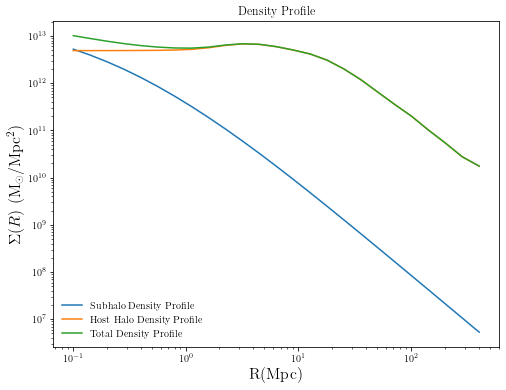

In [43]:
#Plot Density Profiles
fig, ax = plt.subplots(figsize=(8,6), ncols=1)
ax.plot(r_mpc_scales, sigma_term1, label = 'Subhalo Density Profile' )
ax.plot(r_mpc_scales, sigma_term2, label = 'Host Halo Density Profile')
ax.plot(r_mpc_scales, total_density, label = 'Total Density Profile')
ax.set_ylabel(r'$\Sigma(R)$ (M$_\odot$/Mpc$^2$)', fontsize=16)
ax.set_xlabel('R(Mpc)', fontsize=16)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Density Profile')
plt.show()